In [1]:
#installs
!pip install livelossplot --quiet


In [2]:
%reset #clear the ipython workspace variables

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Don't know how to reset  #clear, please run `%reset?` for details
Don't know how to reset  the, please run `%reset?` for details
Don't know how to reset  ipython, please run `%reset?` for details
Don't know how to reset  workspace, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details


In [3]:
%tensorflow_version 2.x

In [5]:
from pandas import Series
from pandas import read_csv
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
import numpy as np
import keras
import matplotlib.pyplot as plt
import pandas as pd
import glob
from keras.layers import Dropout
from sklearn.utils import shuffle
import sys
from pandas import DataFrame
import math
import tensorflow as tf
from tensorflow.python.client import device_lib
import os
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.callbacks import EarlyStopping
import joblib
from livelossplot import PlotLossesKeras


In [6]:
#data is on google drive so need to load
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
#this line needs to be changed depending on file structure of google drive
os.chdir('/content/drive/MyDrive/New LSTM Crack')

In [10]:
#read in the training data file names from folder. Everything with extension *.csv
# Time (s) | Crack Length (m) | Force (N) | Temp (K)
train_files = glob.glob('./Training/HeatTreated/*.csv')
print('Files in use: {}'.format(len(train_files)))
train_files.sort()
print(train_files)
train_df = pd.concat([pd.read_csv(f) for f in train_files]) #read files into pandas frame and concat all data together
#train_df = pd.concat([pd.read_csv(f)[:100000] for f in train_files])
#ok but does it make sense to concatenate the data together??? does order matter?
#the last dataset looks a little too noisy.

Files in use: 9
['./Training/HeatTreated/t150_4-12-21_R05_1800N_training.csv', './Training/HeatTreated/t150_4-13-21_R05_1700N_training.csv', './Training/HeatTreated/t150_4-15-21_R05_1600N_training.csv', './Training/HeatTreated/t250_4-21-21_R05_1800N_training.csv', './Training/HeatTreated/t250_4-7-21_R05_1700N_training.csv', './Training/HeatTreated/t250_4-8-21_R05_1600N_training.csv', './Training/HeatTreated/t35_4-19-21_R05_1800N_training.csv', './Training/HeatTreated/t35_4-2-21_R05_1700N_training.csv', './Training/HeatTreated/t35_4-3-21_R05_1600N_training.csv']


crack_series (2018683, 1)
force_series (2018683, 1)
temp_series (2018683, 1)


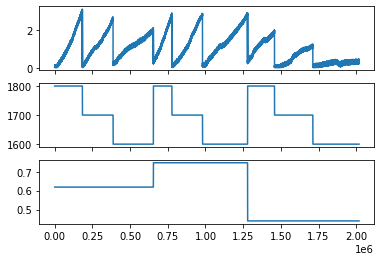

In [11]:
# crack length
crack_series = train_df.iloc[:,1].to_numpy().reshape((len(train_df),1))
# force
force_series = train_df.iloc[:,2].to_numpy().reshape((len(train_df),1))
# normalize the temperature series data by 553K
temp_series = train_df.iloc[:,3].to_numpy().reshape((len(train_df),1))/700

print("crack_series",crack_series.shape)
print("force_series",force_series.shape)
print("temp_series",temp_series.shape)

#let's plot the data to see what is going on
fig, (ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
ax1.plot(crack_series[:,], '-', label='Time') # 
ax2.plot(force_series[:,], '-', label='Force')
ax3.plot(temp_series[:,], '-', label='Temperature')
plt.show()

#so it looks like it is concatenated 1800,1700,1600(med temperature) then 1800,1700,1600(high temperature) then 1800,1700,1600 (room temperature)
#don't quite understand the order or reasoning. but let's see if it works.

In [ ]:
#Calculate the stress intensity
#the geometry of the specimen had to be updated on 5/19/21
stress_intensity = []
specimen_width = 34.63e-3 #meters #40.8 mm new width 34.63mm
thickness = 0.4572e-3 #meters thickness of sample 0.4572mm
a0 = 10e-3 #initial crack length is 10mm
crossSectArea = (specimen_width-a0)*thickness #2.6388 meters 

#looks like you are using the polynomial method derived from FEA to determine stress intensity
for i in range(len(crack_series)):
  term1 = (force_series[i] / crossSectArea) * sqrt(3.14 * crack_series[i])
  term2 = 8.574
  term3 = 10.365 * (crack_series[i] / specimen_width)
  term4 = 5.499 * ((crack_series[i] / specimen_width)**2)
  intensity = term1*(term2 - term3 + term4)
  stress_intensity.append(intensity)
  if i % 100000 == 0:
    print(i)

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000


In [ ]:
stress_intensity = np.asarray(stress_intensity).reshape(len(train_df),1)
Scaler = MinMaxScaler()
Scaler.fit(stress_intensity)
joblib.dump(Scaler, './Weights/Scaler_HT_TM.save')
stress_intensity = Scaler.transform(stress_intensity)
#plot the stress intensity
plt.plot(stress_intensity)

In [8]:
#stack the data 
series= np.hstack((crack_series, temp_series, stress_intensity)) #horizontal stack data

NameError: ignored

In [ ]:
#k-fold data
def k_fold(series, nfolds, train_size, test_size, init_step):
  X, y = list(), list()
  skip_train = int(train_size/(nfolds+1))
  skip_test = int(test_size/nfolds)
  idx=init_step
  for s in range(nfolds):
    test_start =  idx
    test_end =    skip_test-1+idx
    train_start = skip_test+idx
    train_end =   (skip_test+skip_train)+idx
    idx = train_end+1
    print(test_start,test_end)
    seq_x, seq_y = series[test_start:test_end,:], series[train_start:train_end,:]
    X.extend(seq_x)
    y.extend(seq_y)
    print("length of X =",len(seq_x),seq_x.shape)
  return array(X), array(y)

In [ ]:
#there might be an error here. Are you only validating on last case?
train_size = int(len(series) * 0.90)
test_size = len(series) - train_size

#let's try to a k-fold validation
nfolds = 8 #number of folds. let's set it equal to trials
init_step = int(test_size/nfolds*0.1)
#call kfold function
test, train = k_fold(series,nfolds,train_size,test_size,init_step)

#let's set the whole training set to the whole thing.
train = series

#plot crack length, column data 0=crack length, 1=tempature, 2=stress intensity
fig, ax = plt.subplots()
ax.plot(train[:,0], '-', label='Training Data') # store axis (ax) for latter plots
ax.plot(test[:,0], '--', label='Test Data')
ax.set(xlabel='x-label', ylabel='y-label')
ax.legend()
plt.show()

In [ ]:
# function: split a multivariate sequence into samples
# this code will read n_steps samples and associate this with one output.
# see https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern. copy in groups?
		seq_x, seq_y = sequences[i:end_ix, 1:], sequences[end_ix, 0]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [ ]:
# choose a number of time steps to skip when sequencing
n_steps = 3 #number of samples per output
# split into samples
#                                   seqs, nsteps
x_train, y_train = split_sequences(train, n_steps) #seperate data into samples.
x_test, y_test = split_sequences(test, n_steps)
# the samples [i1 i2 i3] [o1 o2] ...
print("size of xtrain =",len(x_train))
print("size of ytrain =",len(y_train))
print("size of xtest =",len(x_test))
print("size of ytest=",len(y_test))

fig, (ax,ax2) = plt.subplots(2,1)
ax.plot(x_train[:,0,0], '-', label='Training Data') # 
ax.plot(x_test[:,0,0], '--', label='Test Data')
ax2.plot(x_train[:,0,1], '-', label='Training Data') # 
ax2.plot(x_test[:,0,1], '--', label='Test Data')
ax.legend()
plt.show()

In [ ]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 2 # temperature, stress intensity
#                          timesteps,                nsamples,           n_features 
x_train_rs = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features)) #reshape train array
x_test_rs = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features)) #reshape test array
#doesn't look like the reshape is necessary. reshapes to the same dimensions

print("x_train.shape[0]",x_train.shape[0])
#print shapes out to figure wtf is going on with data.
print("xtrain",x_train.shape)
print("ytrain",y_train.shape)
print("xtest",x_test.shape)
print("ytest",y_test.shape)

#plot data to compare reshape
fig, (ax,ax2) = plt.subplots(2,1)
ax.plot(x_train[:,0,1], '-', label='Training Data') # 
ax.plot(x_train_rs[:,0,1], '--', label='Training Data Reshape')
ax2.plot(x_test[:,0,1], '-', label='Test Data') # 
ax2.plot(x_test_rs[:,0,1], '--', label='Test Data Reshape')
ax.legend()
plt.show()


In [ ]:
fig, ax = plt.subplots()
ax.plot(y_train[:,], '-', label='Actual') # store axis (ax) for latter plots
ax.plot(y_train_dl, '--', label='Rolling Average')
ax.legend()
plt.show()

In [ ]:
#Select the Keras Model to Run
opt = 0 #option number
if opt == 0:
  #Option 1
  print("Selecting Option 0")
  opt = Adam(learning_rate = 0.0005)
  # define model
  model = Sequential()
  #dropout rate might be too high.
  model.add(Bidirectional(LSTM(100, input_shape=(n_steps, n_features))))
  model.add(Dropout(0.2))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mse')
elif opt == 2:
  #Option 1
  print("Selecting Option 1")
  opt = Adam(learning_rate = 0.0005)
  # define model
  model = Sequential()
  #dropout rate might be too high.
  model.add(Bidirectional(LSTM(1000, activation='relu',return_sequences = True, dropout=0.4), input_shape=(n_steps, n_features)))
  model.add(Dense(500))
  model.add(Bidirectional(LSTM(1000, activation='relu')))
  model.add(Dense(1))
  model.compile(optimizer=opt, loss='mse')
elif opt == 2:
  #Option 2
  print("Selecting Option 2")
  tf.executing_eagerly()
  opt = Adam(learning_rate = 0.0005)
  # define model
  model = Sequential()
  #add more layers
  model.add(Bidirectional(LSTM(20, activation='sigmoid',return_sequences = True, dropout=0.2), input_shape=(n_steps, n_features)))
  model.add(Dense(50))
  model.add(Bidirectional(LSTM(40, activation='sigmoid',return_sequences = True, dropout=0.5)))
  model.add(Dense(100))
  model.add(Bidirectional(LSTM(80, activation='sigmoid',return_sequences = True, dropout=0.5)))
  model.add(Dense(100))
  model.add(Bidirectional(LSTM(160, activation='sigmoid',return_sequences = True, dropout=0.5)))
  model.add(Dense(100))
  model.add(Bidirectional(LSTM(320, activation='sigmoid', dropout=0.5)))
  model.add(Dense(1))
  model.compile(optimizer=opt, loss='mse')
else:
  print("No Selection")
  #do nothing


In [ ]:
#let's ping the GPU and see what colab gave us...
print(tf.test.gpu_device_name())
print(device_lib.list_local_devices())

#let's also check version of tf and if eager is on.
print(tf.executing_eagerly())
print(tf.__version__)
print(keras.__version__)


In [ ]:
# fit model
#let's train on non-smooth data
history = model.fit(x_train, 
                    y_train, 
                    epochs=10, 
                    verbose=1, 
                    batch_size = 256,
                    validation_data=(x_test, y_test),
                    callbacks=[PlotLossesKeras(),EarlyStopping(monitor='val_loss', patience=10)]
                    )

In [ ]:
#predict validation data using trained model
yhat = model.predict(x_test, verbose=1)

In [ ]:
plt.figure()
plt.plot(y_test, label="Actual")
plt.plot(yhat, label="Predicted")
plt.xlabel("Cycle Number")
plt.ylabel("Crake Length")
plt.legend()
plt.show()


In [ ]:
mae =  mean_absolute_error(y_test_dl,yhat)
print(mae)

In [ ]:
#tf.keras.models.save_model("./Weights/Model_HT_5_21_21_TM")
#model.save("./Weights/Model_HT_5_21_21_TM")